In [9]:
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
#import tensorflow as tf
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from sklearn.cross_validation import train_test_split
import scipy.io as sio
%matplotlib inline

In [10]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  return filename

#train_filename = maybe_download('train.tar.gz')
#test_filename = maybe_download('test.tar.gz')

In [3]:
# Download files from ufldl.stanford.edu if not already done
train_matfile = maybe_download('train_32x32.mat')
test_matfile = maybe_download('test_32x32.mat')
valid_matfile = maybe_download('extra_32x32.mat')
dir()

Attempting to download: train_32x32.mat
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!


['Image',
 'In',
 'Out',
 'SGDClassifier',
 '_',
 '__',
 '___',
 '__builtin__',
 '__builtins__',
 '__doc__',
 '__name__',
 '__package__',
 '_dh',
 '_i',
 '_i1',
 '_i2',
 '_i3',
 '_ih',
 '_ii',
 '_iii',
 '_oh',
 '_sh',
 'classification_report',
 'confusion_matrix',
 'display',
 'download_progress_hook',
 'exit',
 'get_ipython',
 'last_percent_reported',
 'maybe_download',
 'ndimage',
 'np',
 'os',
 'pickle',
 'plt',
 'print_function',
 'quit',
 'sio',
 'sys',
 'tarfile',
 'test_matfile',
 'train_matfile',
 'train_test_split',
 'url',
 'urlretrieve',
 'valid_matfile']

In [11]:
#load data
train_dataset = sio.loadmat(train_matfile)
test_dataset = sio.loadmat(test_matfile)
extra_dataset = sio.loadmat(valid_matfile)

#combining datasets
train_data, train_labels = train_dataset['X'], train_dataset['y']
test_data, test_labels = test_dataset['X'], test_dataset['y']
extra_data, extra_labels = extra_dataset['X'], extra_dataset['y']
del train_dataset, test_dataset, extra_dataset

#check health of datasets
print( 'Train data:', train_data.shape,', Train labels:', train_labels.shape )
print( 'Test data:', test_data.shape,', Test labels:', test_labels.shape )
print( 'Extra data:', extra_data.shape,', Extra labels:', extra_labels.shape )

Train data: (32L, 32L, 3L, 73257L) , Train labels: (73257L, 1L)
Test data: (32L, 32L, 3L, 26032L) , Test labels: (26032L, 1L)
Extra data: (32L, 32L, 3L, 531131L) , Extra labels: (531131L, 1L)


In [12]:
# relabel the digit 10 into digit zero for better suitable learning single digits
train_labels[train_labels == 10] = 0
test_labels[test_labels == 10] = 0
extra_labels[extra_labels == 10] = 0

# reshaping np array so that we can access data in CNN suitable format i.e. [i,:,:,:] from [:,:,:,i]
train_data = np.transpose(train_data, (3, 0, 1, 2))
test_data = np.transpose(test_data,(3, 0, 1, 2))
extra_data = np.transpose(extra_data,(3, 0, 1, 2))

# eliminating extra dimension in label vector
train_labels = train_labels[:,0]
test_labels = test_labels[:,0]
extra_labels = extra_labels[:,0]

# combine extra set with training set
total_data = np.concatenate((train_data,extra_data), axis=0)
total_labels = np.concatenate((train_labels,extra_labels), axis=0)

# split in training and validation set
train_data, valid_data, train_labels, valid_labels = train_test_split(total_data, total_labels, train_size=0.9, random_state=106)
del total_data, total_labels, extra_data, extra_labels

# check shape of data after transformation
print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(valid_data.shape, valid_labels.shape)

(543949L, 32L, 32L, 3L) (543949L,)
(26032L, 32L, 32L, 3L) (26032L,)
(60439L, 32L, 32L, 3L) (60439L,)


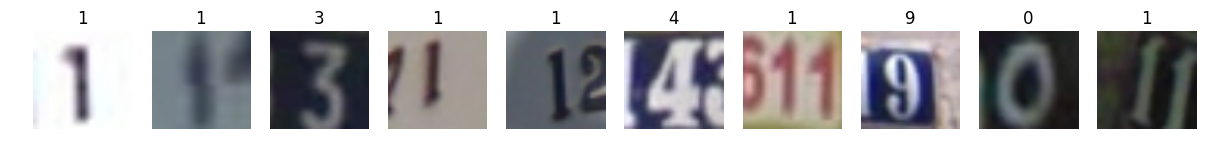

In [13]:
# visual check on data, displaying 10 random pictures

plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_labels.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(train_labels[j], loc='center')
    ax[i].imshow(train_data[j,:,:])

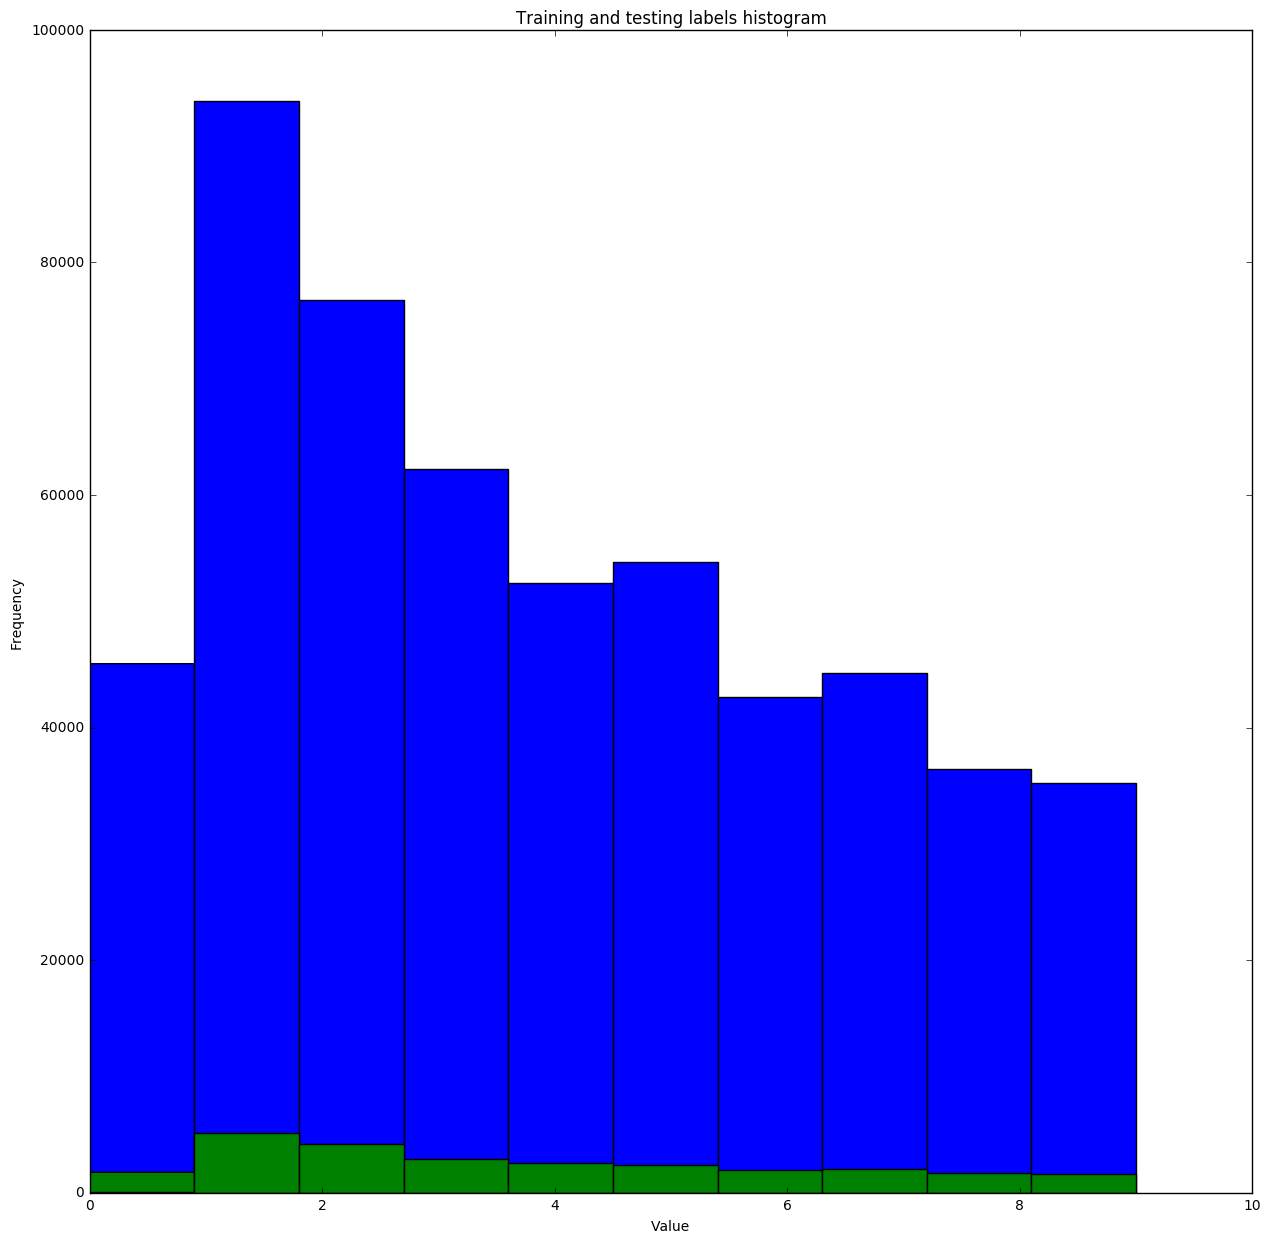

In [26]:
# plot histogram of data distribution

import matplotlib.pyplot as plt
import numpy as np



plt.hist(train_labels, label='training labels' )
plt.hist(test_labels, label='testing labels')
#plt.hist(valid_labels, label='validation labels')
plt.title("Training and testing labels histogram")
plt.xlabel("Value")
plt.ylabel("Frequency")

fig = plt.gcf()




In [ ]:
# converting into grayscale to find edges using luminescence
# http://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python

image_size = 32  # Pixel width and height.
#pixel_depth = 255.0  # Number of levels per pixel.

def im2gray(image):
    image = image.astype(float)
    image_gray = np.dot(image, [[0.2989],[0.5870],[0.1140]])
    return image_gray

train_data_c = im2gray(train_data)[:,:,:,0]
test_data_c = im2gray(test_data)[:,:,:,0]
valid_data_c = im2gray(valid_data)[:,:,:,0]

print(train_data_c.shape, train_labels.shape)
print(test_data_c.shape, test_labels.shape)
print(valid_data_c.shape, valid_labels.shape)

In [ ]:
# normalize data

def normalizer(data):
        
    size_dataset = data.shape[0]
    mean = np.mean(data, axis=(1,2), dtype=float)
    std = np.std(data, axis=(1,2), dtype=float, ddof=1)
    std[std < 1.0e-3] = 1.
    data_norm = np.zeros(data.shape, dtype=float)
    
    for i in np.arange(size_dataset):
        data_norm[i,:,:] = (data[i,:,:] - mean[i]) / std[i]
        
    return data_norm

train_data = normalizer(train_data_c)
del train_data_c
test_data = normalizer(test_data_c)
del test_data_c
valid_data = normalizer(valid_data_c)
del valid_data_c

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(valid_data.shape, valid_labels.shape)

In [ ]:
plt.rcParams['figure.figsize'] = (15.0, 15.0)
f, ax = plt.subplots(nrows=1, ncols=10)

for i, j in enumerate(np.random.randint(0, train_labels.shape[0], size=10)):
    ax[i].axis('off')
    ax[i].set_title(train_labels[j], loc='center')
    ax[i].imshow(train_data[j,:,:])

In [ ]:
# create pickle file for later use
pickle_file = 'SVHN.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_data[:200000,:,:],
    'train_labels': train_labels[:200000],
    'test_dataset': test_data,
    'test_labels': test_labels,
    'valid_dataset': valid_data,
    'valid_labels': valid_labels,    
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

In [ ]:
# create pickle file for later use
pickle_file = 'SVHN_extra.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train2_dataset': train_data[200000:400000,:,:],
    'train2_labels': train_labels[200000:400000]   
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

In [ ]:
# create pickle file for later use
pickle_file = 'SVHN_extra2.pickle'

try:
  f = open(pickle_file, 'wb')
  save = {
    'train3_dataset': train_data[400000:,:,:],
    'train3_labels': train_labels[400000:]   
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise
    
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)